# Imports

In [11]:
import torch
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection, SamModel, SamProcessor
from PIL import Image
from diffusers import StableDiffusionInpaintPipeline
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# Loading models

In [2]:
def load_object_detection_model():
    model_id = "IDEA-Research/grounding-dino-tiny" 
    processor = AutoProcessor.from_pretrained(model_id)
    model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
    
    return model, processor

In [3]:
def load_segmentation_model():
    model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
    
    return model, processor

In [4]:
def load_inpainting_model():
    model = StableDiffusionInpaintPipeline.from_pretrained(
        "runwayml/stable-diffusion-inpainting",
    ).to(device)
    
    return model

In [5]:
object_detector = load_object_detection_model()
segmentation_model = load_segmentation_model()
inpainting_model = load_inpainting_model()

preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

safety_checker/pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [6]:
def detect_object(object_detector, image, text_prompt):
    model, processor = object_detector
    
    inputs = processor(images=image, text=text_prompt, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)

    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        text_threshold=0.3,
        target_sizes=[image.size[::-1]]
    )[0]
    
    if len(results["boxes"]) > 0:
        best_box = results["boxes"][0]
        return best_box.cpu().numpy()
    else:
        print("No object found!")
        return None

In [7]:
def segment_object(segmentation_model, image, bbox):
    model, processor = segmentation_model
    input_boxes = [[[bbox]]]
    inputs = processor(image, input_boxes=input_boxes, return_tensors="pt").to(device)
    outputs = model(**inputs)
    masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
    
    return masks[0][0]

In [8]:
def inpaint_image(inpainting_model, image, mask, prompt):
    mask = (mask[0].cpu().numpy().astype(np.uint8) * 255)
    mask_image = Image.fromarray(mask)
    
    output = inpainting_model(
        prompt=prompt, 
        image=image, 
        mask_image=mask_image
    ).images[0]
    
    return output

In [9]:
def replace(image_path, detect_prompt, replace_prompt):
    raw_image = Image.open(image_path).convert("RGB")
    bbox = detect_object(object_detector, raw_image, detect_prompt)
    
    if bbox is None:
        return
    
    mask = segment_object(segmentation_model, raw_image, bbox)
    
    
    final_image = inpaint_image(inpainting_model, raw_image, mask, replace_prompt)
    
    return final_image

In [31]:
images_ = [np.array(Image.open("/kaggle/input/photos/" + image)) for image in images]

image.dtype

dtype('uint8')

In [33]:
[image.dtype for image in images_]

[dtype('uint8'), dtype('uint8'), dtype('uint8')]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

No object found!


TypeError: Image data of dtype object cannot be converted to float

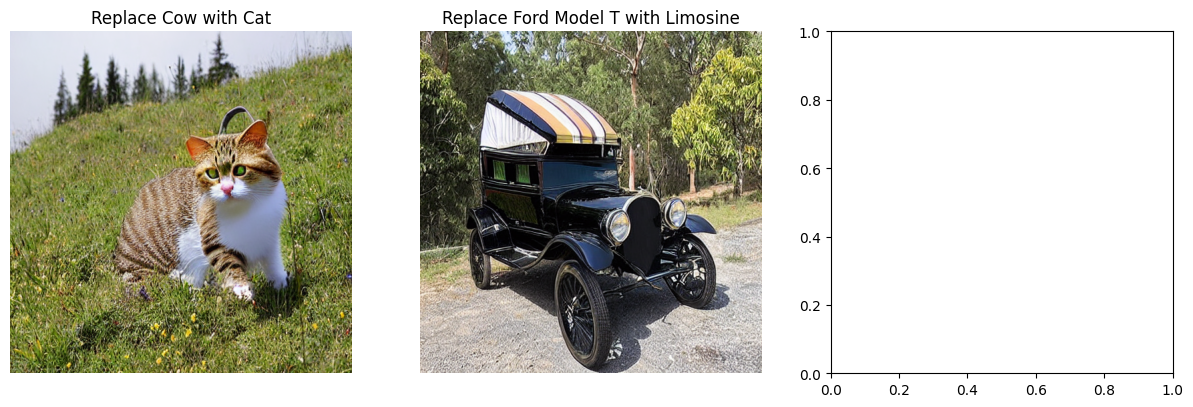

In [ ]:
path = "/kaggle/input/photos/"
images = ["cow.jpg", "ford-model-t.jpg", "vase.jpg"]
detect_prompts = ["Cow", "Car", "vase"]
replace_prompts = ["Cat", "Motorcycle", "Mug"]

plt.figure(figsize=(15, 10))
for i in range(len(images)):
    edited_image = replace(path + images[i], detect_prompts[i], replace_prompts[i])
    plt.subplot(1, len(images), i + 1)
    plt.imshow(edited_image)
    plt.axis('off')
    plt.title(f"Replace {detect_prompts[i]} with {replace_prompts[i]}")
plt.show()    